In [1]:
import numpy as np  # Resolver operaciones de algebra lineal
import pandas as pd  # Procesamiento de datos, archivos CSV

from matplotlib import pyplot as plt

%matplotlib inline

teams = pd.read_csv('/Users/Administrador/Desktop/EuroData/jugadores.csv', sep=";")


rankings = pd.read_csv('/Users/Administrador/Desktop/EuroData/fifa_ranking.csv')
rankings = rankings.replace({'FYR Macedonia': 'North Macedonia'})
rankings = rankings.loc[:, ['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date',
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

rankings['weighted_points'] = rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted']  + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('/Users/Administrador/Desktop/EuroData/results.csv')
matches = matches.replace({'German DR': 'Germany'})
matches['date'] = pd.to_datetime(matches['date'])

euro_cup = pd.read_csv('/Users/Administrador/Desktop/EuroData/grupos_euro.csv', sep=";")
euro_cup = euro_cup[['Team', 'Group', 'First match against', 'Second match against', 'Third match against']]
euro_cup = euro_cup.dropna(how='all')


In [2]:
# Tomamos el ranking para todos los dias
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# Unimos rankings
matches = matches.merge(rankings,
                        left_on=['date', 'home_team'],
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings,
                        left_on=['date', 'away_team'],
                        right_on=['rank_date', 'country_full'],
                        suffixes=('_home', '_away'))

# Agregamos el potencial del equipo al dataset de partidos
teamValue = teams.groupby('squad').mean()['overall']
matches = matches.merge(teamValue, 
                        left_on=['home_team'], 
                        right_on=['squad'])
matches = matches.merge(teamValue, 
                        left_on=['away_team'], 
                        right_on=['squad'], 
                        suffixes=('_home', '_away'))

# Agregar diferencia de potencial entre los equipos
matches['teamValue_difference'] = matches['overall_home'] - matches['overall_away']

# Agregando el potencial del equipo al dataset de copa
euro_cup = euro_cup.merge(teamValue, 
                        left_on=['Team'], 
                        right_on=['squad'])
euro_cup = euro_cup.set_index('Team')

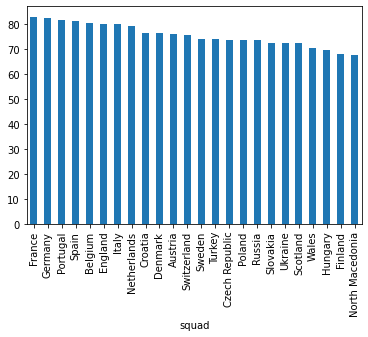

In [3]:
# Graficando el potencial de cada seleccion
# de acuerdo a la jerarquía de sus jugadores
plot = teamValue.sort_values( ascending=False).plot(kind='bar')

In [4]:
# Generamos caracteristicas
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0  # Tomamos el empate como derrota
matches['is_stake'] = matches['tournament'] != 'Friendly'

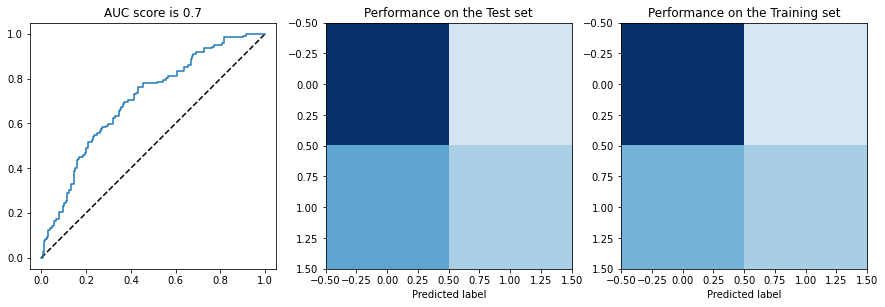

In [5]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:, ['average_rank', 'rank_difference', 'teamValue_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# Graficos
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))
ax.set_aspect(1)

ax = plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim=(0, cm.max()))

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1, 3, 3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim=(0, cm.max()))
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass


Stakes distribution in the wrong predictions
True     0.54
False    0.46
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.560669
False    0.439331
Name: is_stake, dtype: float64


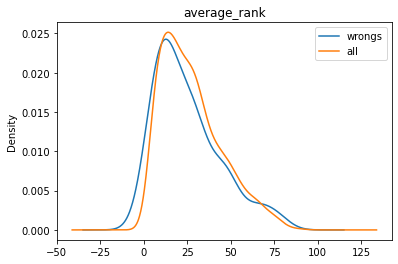

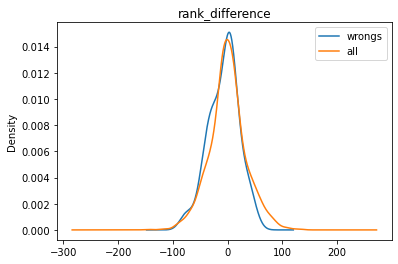

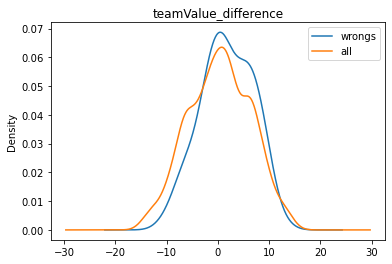

In [6]:
features = ['average_rank', 'rank_difference', 'teamValue_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])

print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

In [7]:
# definimos un pequeño margen para calcular empates
margin = 0.05


euro_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) &
                                    rankings['country_full'].isin(euro_cup.index.unique())]
euro_cup_rankings = euro_cup_rankings.set_index(['country_full'])

In [8]:
from itertools import combinations

opponents = ['First match against', 'Second match against', 'Third match against']

euro_cup['points'] = 0
euro_cup['total_prob'] = 0

for group in set(euro_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(euro_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_points = euro_cup_rankings.loc[home, 'weighted_points']
        opp_points = euro_cup_rankings.loc[away, 'weighted_points']
        home_rank = euro_cup_rankings.loc[home, 'rank']
        opp_rank = euro_cup_rankings.loc[away, 'rank']
        teamValue_home = euro_cup.loc[home, 'overall']
        teamValue_away = euro_cup.loc[away, 'overall']
        
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        #row['point_difference'] = home_points - opp_points
        row['teamValue_difference'] = teamValue_home - teamValue_away

        home_win_prob = model.predict_proba(row)[:, 1][0]
        euro_cup.loc[home, 'total_prob'] += home_win_prob
        euro_cup.loc[away, 'total_prob'] += 1 - home_win_prob

        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1 - home_win_prob))
            euro_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            euro_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            euro_cup.loc[home, 'points'] += 1
            euro_cup.loc[away, 'points'] += 1

___Starting group C:___
Austria vs. North Macedonia: Austria wins with 0.73
Austria vs. Netherlands: Netherlands wins with 0.64
Austria vs. Ukraine: Draw
North Macedonia vs. Netherlands: Netherlands wins with 0.89
North Macedonia vs. Ukraine: Ukraine wins with 0.81
Netherlands vs. Ukraine: Netherlands wins with 0.56
___Starting group F:___
Hungary vs. Portugal: Portugal wins with 0.83
Hungary vs. France: France wins with 0.84
Hungary vs. Germany: Germany wins with 0.84
Portugal vs. France: France wins with 0.58
Portugal vs. Germany: Germany wins with 0.60
France vs. Germany: Germany wins with 0.61
___Starting group D:___
England vs. Croatia: Draw
England vs. Scotland: England wins with 0.61
England vs. Czech Republic: England wins with 0.61
Croatia vs. Scotland: Draw
Croatia vs. Czech Republic: Draw
Scotland vs. Czech Republic: Czech Republic wins with 0.60
___Starting group A:___
Turkey vs. Italy: Italy wins with 0.71
Turkey vs. Wales: Wales wins with 0.61
Turkey vs. Switzerland: Swit

In [9]:
euro_cup = euro_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = euro_cup.groupby('Group').nth([0, 1, 2])  # select the top 3
next_round_wc = next_round_wc.reset_index()
next_round_wc[['Group', 'Team', 'points']]
next_round_wc = next_round_wc.sort_values(by=['Group', 'points', 'total_prob'], ascending=[True, False, False])
next_round_wc = next_round_wc.reset_index(drop = True)
next_round_wc

,Group,Team,First match against,Second match against,Third match against,overall,points,total_prob
0,A,Switzerland,Wales,Italy,Turkey,75.538462,9,1.951418
1,A,Italy,Turkey,Switzerland,Wales,80.153846,4,1.634542
2,A,Wales,Switzerland,Turkey,Italy,70.384615,4,1.440536
3,B,Belgium,Russia,Denmark,Finland,80.538462,9,2.190850
4,B,Denmark,Finland,Belgium,Russia,76.423077,6,1.663355
5,B,Russia,Belgium,Finland,Denmark,73.653846,3,1.444184
6,C,Netherlands,Ukraine,Austria,North Macedonia,79.153846,9,2.093087
7,C,Ukraine,Netherlands,North Macedonia,Austria,72.615385,4,1.750027
8,C,Austria,North Macedonia,Netherlands,Ukraine,76.153846,4,1.584922
9,D,England,Croatia,Scotland,Czech Republic,80.192308,7,1.684634


In [10]:
emparejamiento = [3, 17, 0, 10, 15, 2, 8, 13, 12, 11, 6, 16, 9, 7, 1, 4]
next_round_wc = next_round_wc.loc[emparejamiento]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']
euro_cup = euro_cup.set_index(['Team'])
labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i * 2]
        away = next_round_wc.index[i * 2 + 1]
        print("{} vs. {}: ".format(home,
                                   away),
              end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = euro_cup_rankings.loc[home, 'rank']
        opp_rank = euro_cup_rankings.loc[away, 'rank']
        home_points = euro_cup_rankings.loc[home, 'weighted_points']
        opp_points = euro_cup_rankings.loc[away, 'weighted_points']
        teamValue_home = euro_cup.loc[home, 'overall']
        teamValue_away = euro_cup.loc[away, 'overall']
        
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        #row['point_difference'] = home_points - opp_points
        row['teamValue_difference'] = teamValue_home - teamValue_away

        home_win_prob = model.predict_proba(row)[:, 1][0]
        if model.predict_proba(row)[:, 1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1 - home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(euro_cup_rankings.loc[home, 'country_abrv'],
                                                         1 / home_win_prob,
                                                         euro_cup_rankings.loc[away, 'country_abrv'],
                                                         1 / (1 - home_win_prob)))
        odds.append([home_win_prob, 1 - home_win_prob])

    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Belgium vs. Portugal: Portugal wins with probability 0.59
Switzerland vs. Czech Republic: Switzerland wins with probability 0.54
Germany vs. Wales: Germany wins with probability 0.55
Austria vs. Sweden: Sweden wins with probability 0.57
Spain vs. Croatia: Croatia wins with probability 0.52
Netherlands vs. France: France wins with probability 0.64
England vs. Ukraine: England wins with probability 0.58
Italy vs. Denmark: Denmark wins with probability 0.58


___Starting of the quarterfinal___
Portugal vs. Switzerland: Switzerland wins with probability 0.56
Germany vs. Sweden: Germany wins with probability 0.55
Croatia vs. France: France wins with probability 0.66
England vs. Denmark: Denmark wins with probability 0.56


___Starting of the semifinal___
Switzerland vs. Germany: Germany wins with probability 0.61
France vs. Denmark: Denmark wins with probability 0.53


___Starting of the final___
Germany vs. Denmark: Denmark wins with probability 0.52


